# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d

from scipy.linalg import det

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()
    
def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def Sobel(I):
    """ Array*double -> Array """
    Sx = np.array([[1,0,-1],
                   [2,0,-2],
                   [1,0,-1]])
    Sy = np.array([[1,  2, 1],
                   [0,  0, 0],
                   [-1,-2,-1]])
    Ix = convolve2d(I,Sx)
    Iy = convolve2d(I,Sy)
    return Ix, Iy

In [3]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    n, m = image.shape
    Ix, Iy = Sobel(image)
    A = Ix * Ix
    B = Iy * Iy
    C = Ix * Iy
    sigma = ((round((scale-1)/2+1))-1)/3
    w = gaussianKernel(sigma)
    wA = convolve2d(w,A)
    wB = convolve2d(w,B)
    wC = convolve2d(w,C)
    M = np.zeros((n,m,2,2))
    R = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            M[i][j][0][0] = wA[i][j]
            M[i][j][1][1] = wB[i][j]
            M[i][j][1][0] = wC[i][j]
            M[i][j][0][1] = wC[i][j]
            detM = det(M[i][j])
            traceM = np.trace(M[i][j])
            R[i][j] = detM - kappa * traceM**2
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

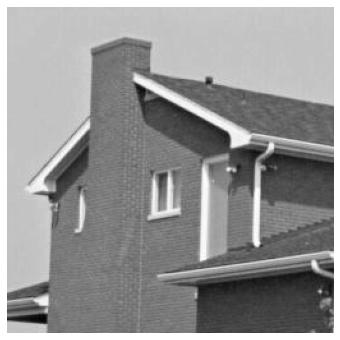

In [4]:
kappa = 0.04
scale = 15
house2 = np.array(Image.open('img/house2.png'))

imshow(house2)
R_house2 = computeR(house2, scale, kappa)

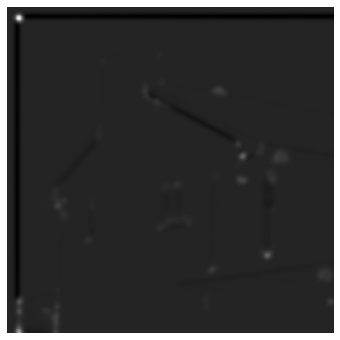

[[-3.08789540e-03  4.20224116e-02  2.64756124e+00 ... -5.67238573e+04
  -5.67796071e+04 -5.68661776e+04]
 [ 4.20224116e-02  1.49455930e+01  2.99634733e+02 ... -1.04861811e+06
  -1.04969406e+06 -1.05130947e+06]
 [ 2.64756124e+00  2.99634733e+02  4.93404617e+03 ... -8.66647334e+06
  -8.67543356e+06 -8.68880840e+06]
 ...
 [-2.92114105e+03  1.43534806e+05  2.62902223e+06 ...  8.10503430e+05
   1.40825987e+06  2.68770706e+06]
 [-7.46391533e+03  1.02013232e+05  2.65588090e+06 ...  8.70295670e+05
   1.45994445e+06  2.69562073e+06]
 [-1.52566157e+04 -2.44164761e+04  1.75696881e+06 ...  8.49810742e+05
   1.41278252e+06  2.63605682e+06]]


In [5]:
imshow(R_house2)
print(R_house2)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

In [6]:
# On voit bien les coins (les points), les contours (lignes noires) et les régions (gris en fond).
# Pour chaque pixel de l'image on a calculer la valeur R.
# Cette valeur R permet de connaître les coins, contours et régions grâce au signe de R.
# Cela explique les differentes couleurs suivants ces éléments quand on imshow(R)

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [7]:
def thresholdR(R, thres):
    return np.where(R > thres, 1, 0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [8]:
def rnms(R, Rbin, taille_fenetre):
    new_image = np.zeros((R.shape))
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if Rbin[i][j] == 0:
                    continue
            if(i < 255 and j < 255):
                neighbors = []
                for k in range(int(-taille_fenetre/2), int(taille_fenetre/2+1), 1):
                    for l in range(int(-taille_fenetre/2), int(taille_fenetre/2+1), 1):
                        neighbors.append(R[i+k][j+l])
                w = np.max(neighbors)
                if(w == R[i][j]):
                    new_image[i][j] = 1
    return new_image

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [9]:
def cornerDetector(image, scale, kappa, thres, taille_fenetre):
    new_image = np.zeros((image.shape))
    R = computeR(image,scale,kappa)
    Rbin = thresholdR(R,thres)
    new_image = rnms(R,Rbin,taille_fenetre)
    return new_image

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

In [10]:
thres = 10**5.8
taille_fenetre = 3
kappa = 0.04
scale = 2.14

coins_image = cornerDetector(house2, scale, kappa, thres, taille_fenetre) 

In [11]:
print(coins_image.mean())

0.00347900390625


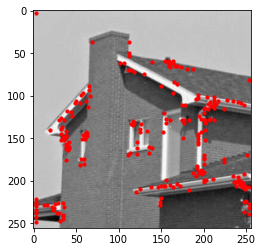

In [12]:
plt.figure()
plt.imshow(house2)
coins = np.nonzero(coins_image)
plt.scatter(coins[1],coins[0],s=10,c="#ff0000" )
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

In [13]:
# n = 9
# thres = 10**6.8
# taille_fenetre = 3
# kappa = 0.04
# scale = 2.14

# fig=plt.figure(figsize=(15,15))
# for i in range(1,n+1):
#     fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i)
#     coins_image = cornerDetector(house2, scale, kappa, thres, taille_fenetre)     
#     plt.imshow(house2)
#     coins = np.nonzero(coins_image)
#     plt.scatter(coins[1],coins[0],s=10,c="#ff0000")
#     plt.title('f Scale: {}, Wind: {}, Kappa: {}, Thre: {}'.format(scale, taille_fenetre, kappa, thres))
#     plt.show()
#     kappa -= 0.0025

In [14]:
# n = 9
# thres = 10**6.8
# taille_fenetre = 3
# kappa = 0.04
# scale = 2.14

# fig = plt.figure(figsize=(15,15))
# for i in range(1,n+1):
#     fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i)
#     coins_image = cornerDetector(house2, scale, kappa, thres, taille_fenetre)     
#     plt.imshow(house2)
#     coins = np.nonzero(coins_image)
#     plt.scatter(coins[1],coins[0],s=10,c="#ff0000")
#     plt.title('f Scale: {}, Wind: {}, Kappa: {}, Thre: {}'.format(scale, taille_fenetre, kappa, thres))
#     plt.show()
#     thres /= 10

In [15]:
# n = 9
# thres = 10**6.8
# taille_fenetre = 3
# kappa = 0.04
# scale = 2.14

# fig = plt.figure(figsize=(15,15))
# for i in range(1,n+1):
#     fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i)
#     coins_image = cornerDetector(house2, scale, kappa, thres, taille_fenetre)     
#     plt.imshow(house2)
#     coins = np.nonzero(coins_image)
#     plt.scatter(coins[1],coins[0],s=10,c="#ff0000")
#     plt.title('f Scale: {}, Wind: {}, Kappa: {}, Thre: {}'.format(scale, taille_fenetre, kappa, thres))
#     plt.show()
#     taille_fenetre += 1

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

In [16]:
# horse = np.array(Image.open('img/toyHorse1.png'))
# horse2 = np.array(Image.open('img/toyHorse2.png'))

In [17]:
# coinsimage=cornerDetector(horse, 2.1, 0.04, 10**3)
# plt.figure()
# plt.imshow(horse)
# coins=np.nonzero(coinsimage)
# plt.scatter(coins[1],coins[0],s=10,c="#ff0000" )
# plt.show()

In [18]:
# coinsimage=cornerDetector(horse2, 2.5, 0.04, 10**5.8)
# plt.figure()
# plt.imshow(horse)
# coins=np.nonzero(coinsimage)
# plt.scatter(coins[1],coins[0],s=10,c="#ff0000" )
# plt.show()

2) What are the dynamic ranges of these two images ?

In [19]:
# Il y a un changement de luminosité et une rotation de la seconde image.

3) What are the transformations beetween the two images ?

In [20]:
# D'un point de vue expérimental, oui la détection est invariante à la rotation mais pas à la transformation affine de la luminosité.
# Nous pouvons voir un petit changement dans la luminosité et le seuil de détection.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

In [21]:
# 

# Exercice supplémentaire :

In [22]:
import cv2

house2 = cv2.imread("img/house2.png")
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2RGB)
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2GRAY).astype(float)/255

In [23]:
kappa = 0.04
scale = 2.14

In [24]:
def imshow_colorbar(I, title=None, size=800, axis=False):
    plt.figure(figsize=(size//80, size//80))
    plt.imshow(I)
    plt.colorbar()
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def get_imgs(image,scale,kappa):
    n, m = image.shape
    Ix, Iy = Sobel(image)
    A = Ix * Ix
    B = Iy * Iy
    C = Ix * Iy
    sigma = ((round((scale-1)/2+1))-1)/3
    w = gaussianKernel(sigma)
    wA = convolve2d(w,A)
    wB = convolve2d(w,B)
    wC = convolve2d(w,C)
    M = np.zeros((n,m,2,2))
    R = np.zeros((n,m))
    L_max = np.zeros(image.shape)
    L_min = np.zeros(image.shape)
    detM = np.zeros(image.shape)
    traceM = np.zeros(image.shape)
    for i in range(n):
        for j in range(m):
            M[i][j][0][0] = wA[i][j]
            M[i][j][1][1] = wB[i][j]
            M[i][j][1][0] = wC[i][j]
            M[i][j][0][1] = wC[i][j]
            detM[i][j] = det(M[i][j])
            traceM[i][j] = np.trace(M[i][j])
            R[i][j] = detM[i][j] - kappa * traceM[i][j]**2
            L, _ = np.linalg.eig(M[i][j])
            L_min[i,j] = np.minimum(L[0],L[1])
            L_max[i,j] = np.maximum(L[0],L[1])
    return R, L_min, L_max, traceM, detM

In [25]:
R, L_min, L_max, traceM, detM = get_imgs(house2, scale, kappa)

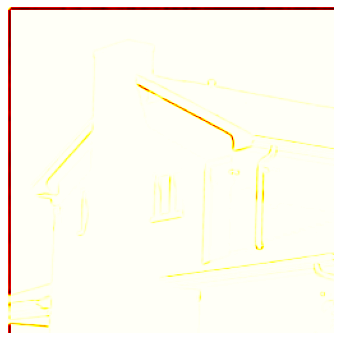

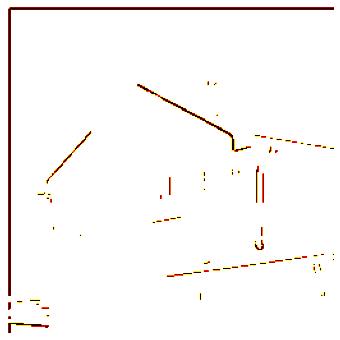

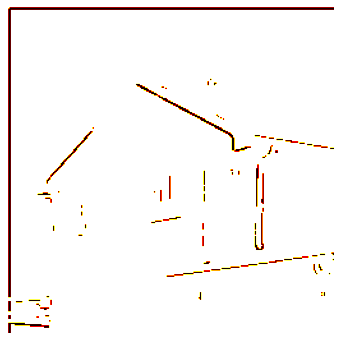

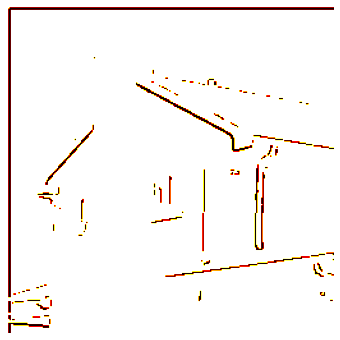

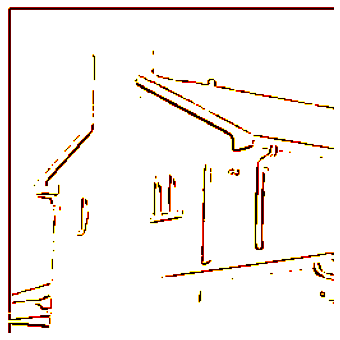

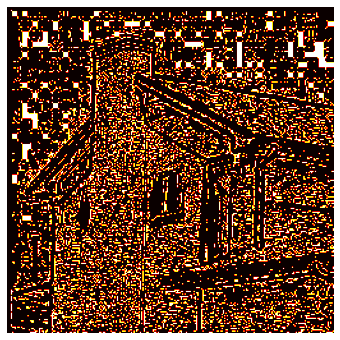

In [26]:
thres = -0.4

imshow_hot(R)

for i in range(5):
    R_tmp = thresholdR(R, thres)
    imshow_hot(R_tmp)
    thres += 0.1

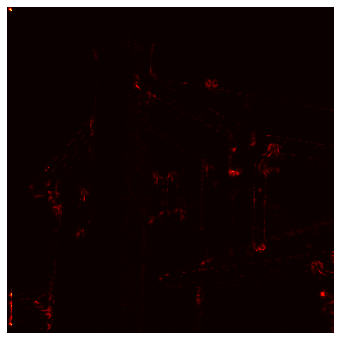

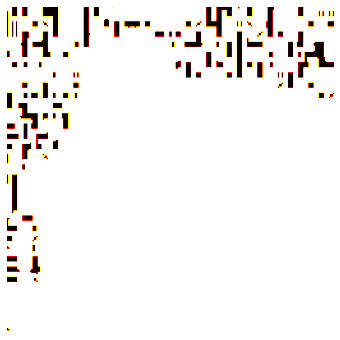

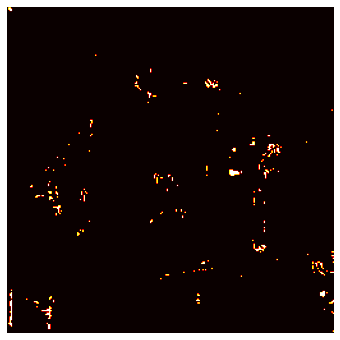

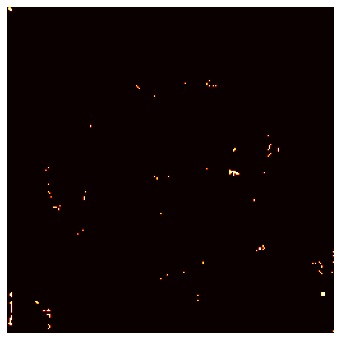

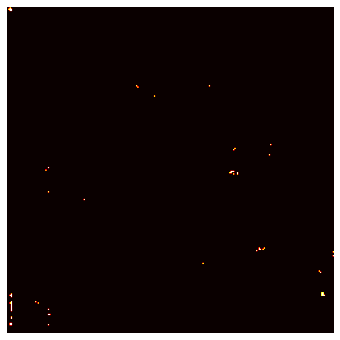

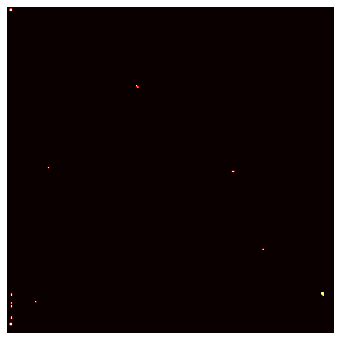

In [27]:
thres = 0

imshow_hot(L_min)

for i in range(5):
    L_min_tmp = thresholdR(L_min, thres)
    imshow_hot(L_min_tmp)
    thres += 0.01

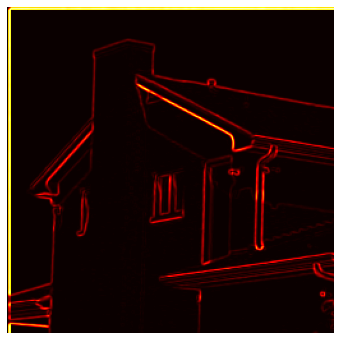

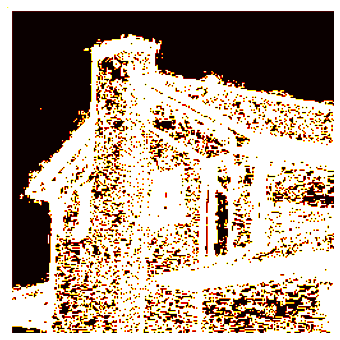

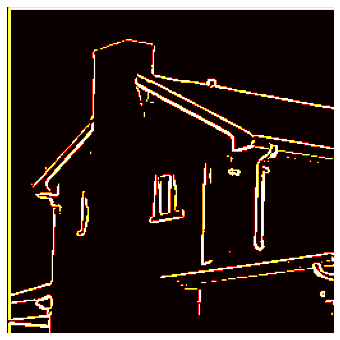

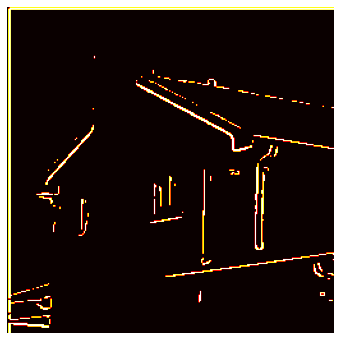

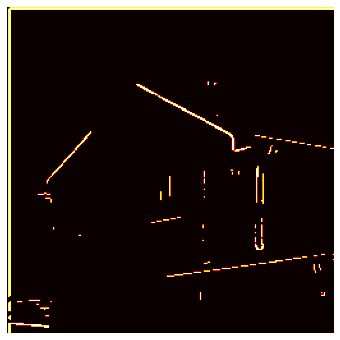

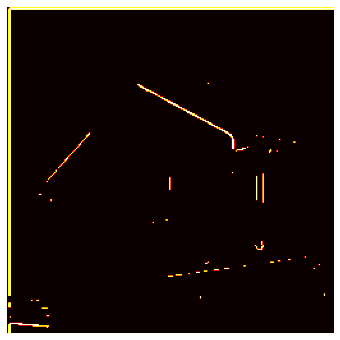

In [28]:
thres = 0.005

imshow_hot(L_max)
    
for i in range(5):
    L_max_tmp = thresholdR(L_max, thres)
    imshow_hot(L_max_tmp)
    thres += 1

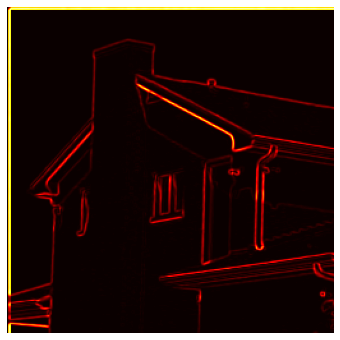

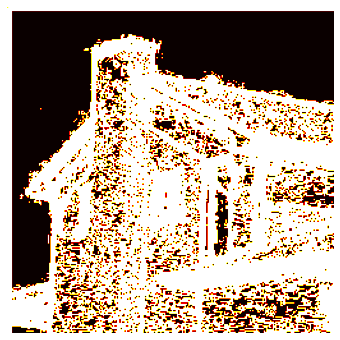

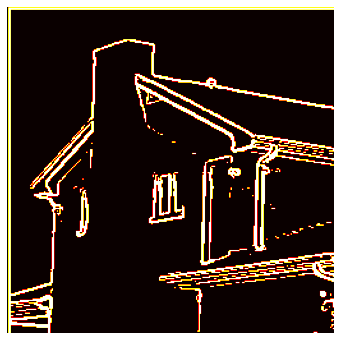

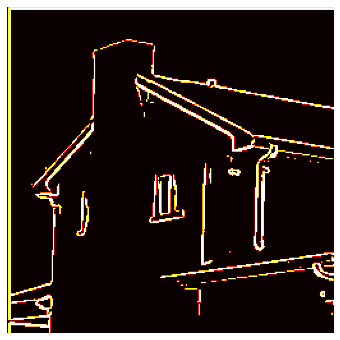

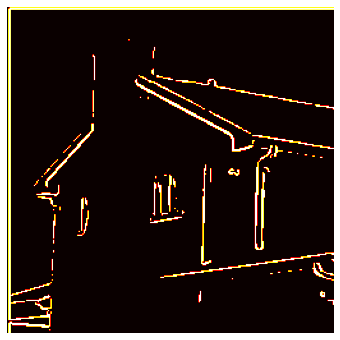

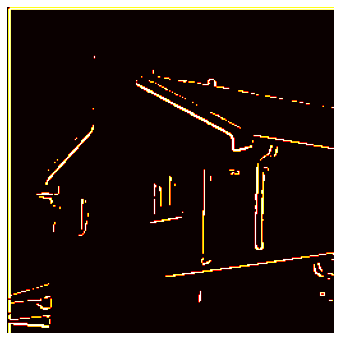

In [29]:
thres = 0.005
   
imshow_hot(traceM)
    
for i in range(5):
    traceM_tmp = thresholdR(traceM, thres)
    imshow_hot(traceM_tmp)
    thres += 0.5

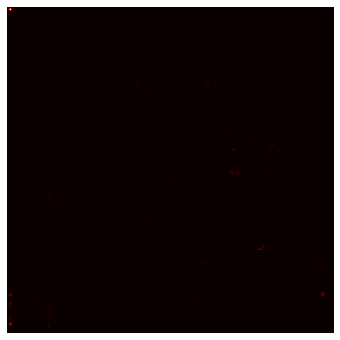

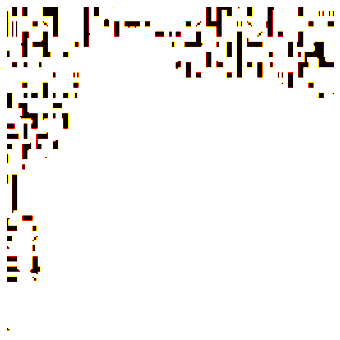

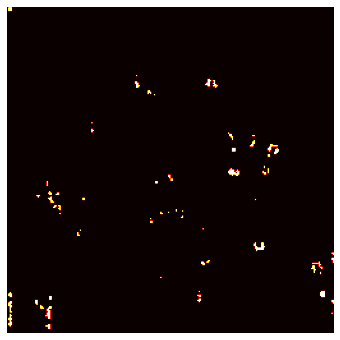

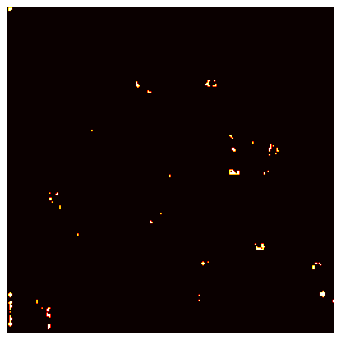

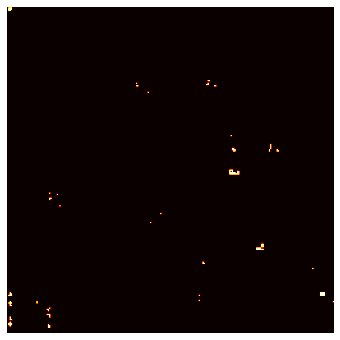

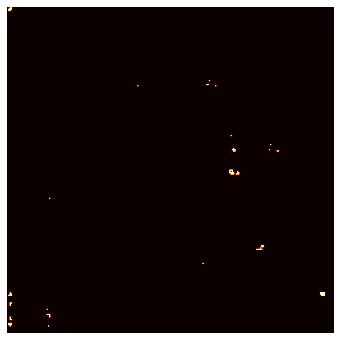

In [30]:
thres = 0

imshow_hot(detM)
    
for i in range(5):
    detM_tmp = thresholdR(detM, thres)
    imshow_hot(detM_tmp)
    thres += 0.01

In [31]:
tmp = detM/traceM
tmp[np.isnan(tmp)] = 0

<ipython-input-31-a143924d300a>:1: RuntimeWarning: invalid value encountered in true_divide
  tmp = detM/traceM


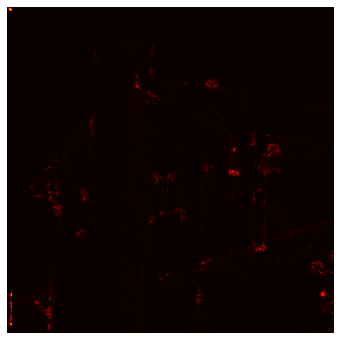

In [32]:
imshow_hot(tmp)

# Avec la librairie cv2

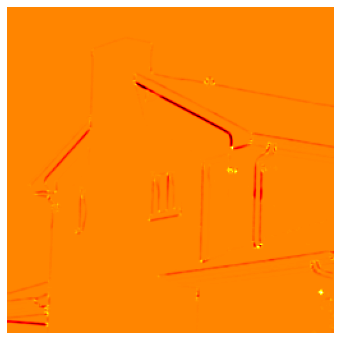

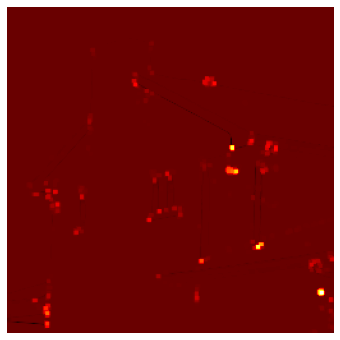

In [33]:
house2 = cv2.imread("img/house2.png")
house2_color = house2
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2RGB)
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2GRAY).astype(float)/255
house2_cv2 = np.float32(house2)

harris = cv2.cornerHarris(house2_cv2, 2, 3, 0.04)
imshow_hot(harris)

dilate = cv2.dilate(harris, None)
imshow_hot(dilate)